# Autoregressive Models

On this Notebook, some Autoregressive Models are tried in the job to solve the competition problem. The idea here is to find the most suitable model to use on an Ensemble with other constructed model.

## Libraries

In [1]:
import numpy as np 
import pandas as pd 
from cnr_methods import get_simplified_data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

from fbprophet import Prophet
from arch import arch_model
import pmdarima as pm

Importing plotly failed. Interactive plots will not work.


## Data Extraction

In [2]:
full_data, full_label = get_simplified_data()

To simplify the analysis, let's work only with Training Data of Wind Farm 1.

In [3]:
X = full_data[full_data['Set']=='Train']
X = X[X['WF']=='WF3']
y = full_label[full_label.index.isin(X['ID'])]

## Facebook Prophet

The First method that will be tried is the Facebooks's Prophet. First thing to do is convert the data to the Standard Format required by Prophet.

In [4]:
y = y.reset_index()
y = y.merge(X.reset_index()[['Time','ID']],on='ID',how='left')
y = y[['Time','Production']]
y.columns = ['ds','y']

In [5]:
y.head()

ds     y
0 2018-05-01 01:00:00  1.49
1 2018-05-01 02:00:00  2.48
2 2018-05-01 03:00:00  2.21
3 2018-05-01 04:00:00  1.49
4 2018-05-01 05:00:00  1.25

Let's divide the Data on Train and Hold Set. As the data has nearly 8 months of data, we'll separate the last month as the Holdout Set.

In [6]:
split = round(7*len(y)/8)

y_train = y[:split]
y_hold = y[split:]

Now, let's apply the Model.

In [7]:
m = Prophet(growth='logistic',n_changepoints=25,changepoint_prior_scale = 10000,yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=False)
#m.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=100)

In [8]:
y_train['floor'] = 0
y_train['cap'] = 10

In [9]:
m.fit(y_train)

In [10]:
future = m.make_future_dataframe(periods=780,freq='H',include_history=True)

In [11]:
future['floor'] = 0
future['cap'] = 10

In [12]:
forecast = m.predict(future)

In [13]:
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

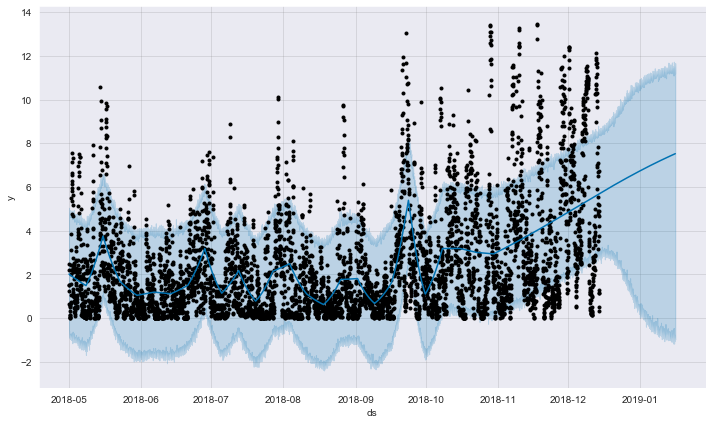

In [14]:
fig1 = m.plot(forecast)

In [15]:
preds = forecast[-780:]

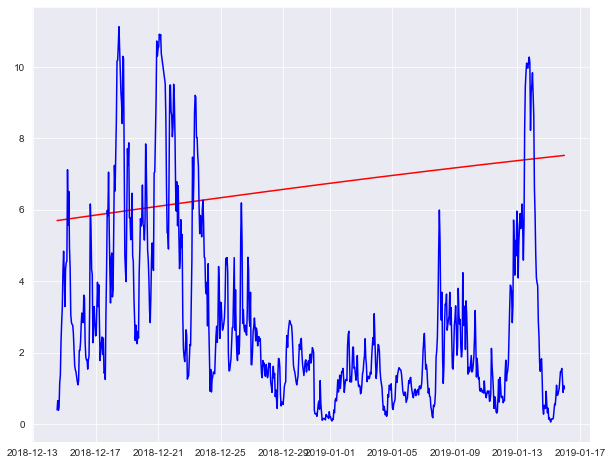

In [16]:
plt.figure(figsize=(10,8))
plt.plot(preds['ds'],preds['yhat'],'r',label='Predictions')
plt.plot(preds['ds'],y_hold['y'],'b',label='True Values')

## ARIMA

In [17]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

In [18]:
def get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(10) 
    d_rng = range(3) 
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [19]:
#y_train['y'] = np.log(y_train['y'] + 1)
#y_hold['y'] = np.log(y_hold['y'] + 1)

### ARIMA Model

Here, we implement the ARIMA Model.

In [20]:
aic,order,model = get_best_model(y_train['y'])

C:\Users\andre_\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\andre_\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\andre_\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\andre_\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\andre_\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_r

In [21]:
print(model.summary())

ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 5458
Model:                 ARIMA(8, 1, 8)   Log Likelihood               -6588.385
Method:                           mle   S.D. of innovations              0.809
Date:                Thu, 18 Jun 2020   AIC                          13210.771
Time:                        23:28:25   BIC                          13323.053
Sample:                             1   HQIC                         13249.950
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y      0.8927      0.114      7.809      0.000       0.669       1.117
ar.L2.D.y      0.7779      0.140      5.550      0.000       0.503       1.053
ar.L3.D.y     -0.8516      0.046    -18.713      0.000      -0.941      -0.762
ar

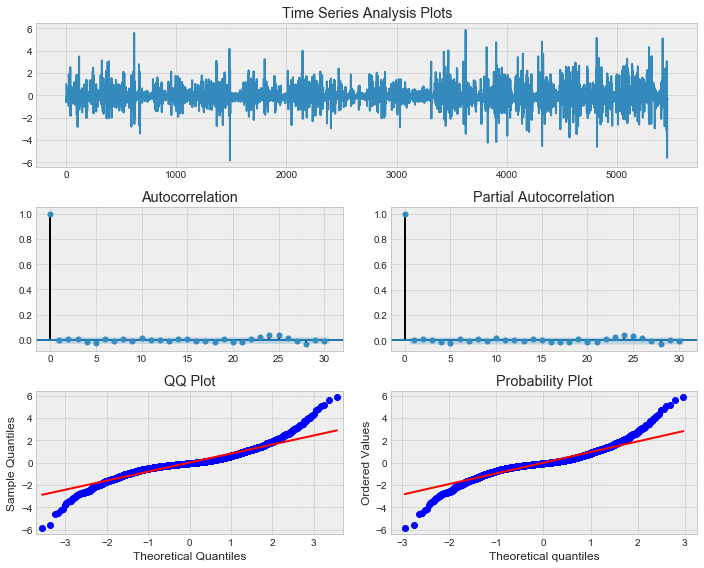

In [22]:
tsplot(model.resid, lags=30)

In [23]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(model.resid**2)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.')

We have reason to suspect the residuals are not normally distributed.


### GARCH Model

In [24]:
p_ = order[0]
o_ = order[1]
q_ = order[2]

In [25]:
am = arch_model(model.resid, p=p_, o=o_, q=q_,dist='StudentsT',mean='Zero')
res = am.fit(disp='off')
print(res.summary())

Zero Mean - GJR-GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -4847.19
Distribution:      Standardized Student's t   AIC:                           9732.38
Method:                  Maximum Likelihood   BIC:                           9857.88
                                              No. Observations:                 5458
Date:                      Thu, Jun 18 2020   Df Residuals:                     5439
Time:                              23:28:39   Df Model:                           19
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0237  4.

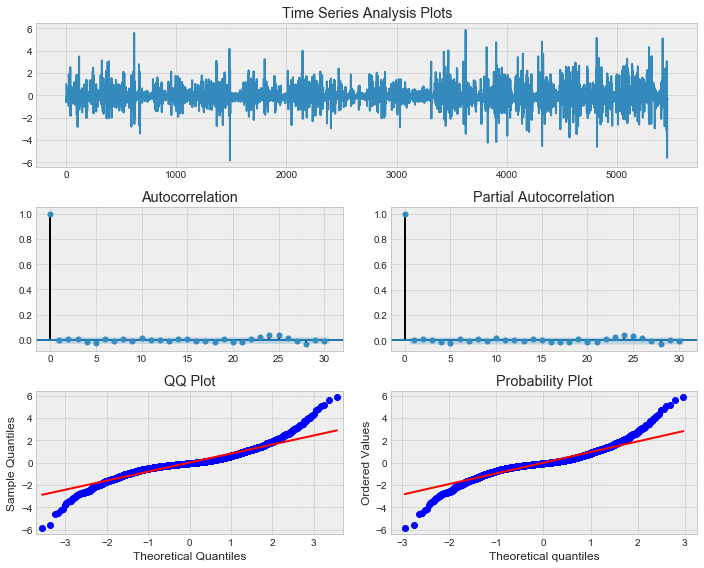

In [26]:
tsplot(res.resid, lags=30)

### Forecast Generation

In [27]:
garch_forecasts = res.forecast(horizon=780)

In [28]:
garch_forecasts = pd.DataFrame(garch_forecasts.variance.iloc[-1])
garch_forecasts = garch_forecasts.reset_index().drop('index',axis=1)
garch_forecasts = garch_forecasts.rename({5458:'Forecasts'},axis=1)

In [29]:
noise = pd.DataFrame(np.random.normal(0,1,780),columns=['Noise'])

In [30]:
garch_forecasts['Forecasts'] = np.sqrt(garch_forecasts['Forecasts']) * noise['Noise']
garch_forecasts.index = y_hold.index

In [31]:
fc, se, conf = model.forecast(780, alpha=0.05)  # 95% conf

In [32]:
fc_series = pd.Series(fc, index=y_hold.index)
lower_series = pd.Series(conf[:, 0], index=y_hold.index)
upper_series = pd.Series(conf[:, 1], index=y_hold.index)

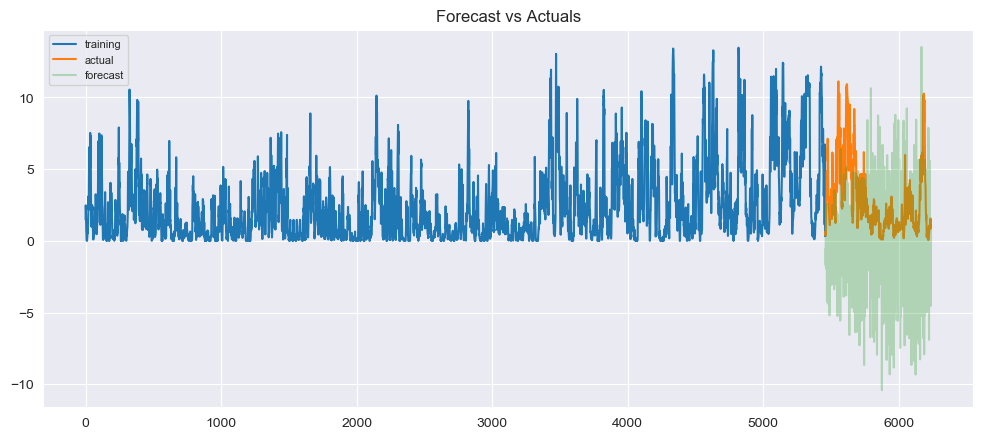

In [33]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train['y'], label='training')
plt.plot(y_hold['y'], label='actual')
plt.plot(garch_forecasts, label='forecast',alpha=0.3)
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()